In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import sys
import nmmn.plots
import seaborn as sns
import os
import time
from scipy import interpolate
sys.path.append('../Code')
import PSTHM 
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

In [3]:
rsl_data = np.loadtxt('Maine_RSL/MaineBarilsiteall.dat')
X = rsl_data[:,2]
y = rsl_data[:,5]
lat = rsl_data[:,0]
lon = rsl_data[:,1]
x_sigma = (rsl_data[:,3]+rsl_data[:,4])/4
y_sigma = (rsl_data[:,6]+rsl_data[:,7])/4
data_type = rsl_data[:,8]
SLIP_index = data_type==0
TL_index = data_type==1
ML_index = data_type==-1

X_all = np.vstack([X,lat,lon]).T 

In [10]:
import scipy.io
# GIA_1 = scipy.io.loadmat('Maine_RSL/ice6g_72p515_RSL.mat')
# GIA_2 = scipy.io.loadmat('Maine_RSL/ice6g_96p515_RSL.mat')
# GIA_3 = scipy.io.loadmat('Maine_RSL/ice6g_vm2_RSL.mat')
# coor = scipy.io.loadmat('Maine_RSL/LONLAT256.mat')
test = scipy.io.loadmat('Maine_RSL/Bonneville_3D_runs_p55.mat')


In [794]:
from scipy.interpolate import RegularGridInterpolator as rgi
W_lon =coor['LON'][0,:]
W_lon[W_lon<0]+=360
GIA_1_interp = rgi((GIA_3['time'][32:,0][::-1],coor['LAT'][:,0][::-1],coor['LON'][0,:]), np.array([*GIA_1['RSL'][:,0][32:]])[::-1,::-1])
GIA_2_interp = rgi((GIA_3['time'][32:,0][::-1],coor['LAT'][:,0][::-1],coor['LON'][0,:]), np.array([*GIA_2['RSL'][:,0][32:]])[::-1,::-1])
GIA_3_interp = rgi((GIA_3['time'][32:,0][::-1],coor['LAT'][:,0][::-1],coor['LON'][0,:]), np.array([*GIA_3['RSL'][:,0][32:]])[::-1,::-1])
#transfer longitude from -180-180 to 0-360
X_new = torch.clone(torch.tensor(X_all))
X_new[:,2]+=360
GIA_1_pred = GIA_1_interp(X_new)
GIA_2_pred = GIA_2_interp(X_new)
GIA_3_pred = GIA_3_interp(X_new)

In [4]:
SLIP_X_all = torch.tensor(X_new[SLIP_index])
SLIP_y = torch.tensor(y[SLIP_index])
SLIP_age_sigma = torch.tensor(x_sigma[SLIP_index])
SLIP_y_sigma = torch.tensor(y_sigma[SLIP_index])
st = time.time() 

pyro.clear_param_store()

#define locally non-linar spatio-temporal kernel
local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(20.)))
local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(50.**2)))
local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.4)))
local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

#define whitenoise kernel
whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

#combine all kernels
combined_sp_kernel = gp.kernels.Sum(local_nl_kernel,whitenoise_kernel)

#----define mean function
# the first number (2) here means there are 2 GIA models to interpolate
mean_fn = PSTHM.GIA_ensemble([GIA_1_interp,GIA_2_interp,GIA_3_interp])
mean_fn.set_prior('w',dist.Dirichlet(torch.ones(3)))
mean_fn.set_prior('s',dist.Normal(torch.tensor(1.0),torch.tensor(0.001)))

gpr = PSTHM.GPRegression_V(SLIP_X_all, SLIP_y, combined_sp_kernel,noise=torch.tensor(SLIP_y_sigma**2),jitter=1e-5,mean_function=mean_fn)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=SLIP_age_sigma,num_iteration=300,lr=0.3,decay_r = 0.9,step_size=50)
axes = PSTHM.plot_track_list(track_list)

#calulate log likelihood of the model prediction

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


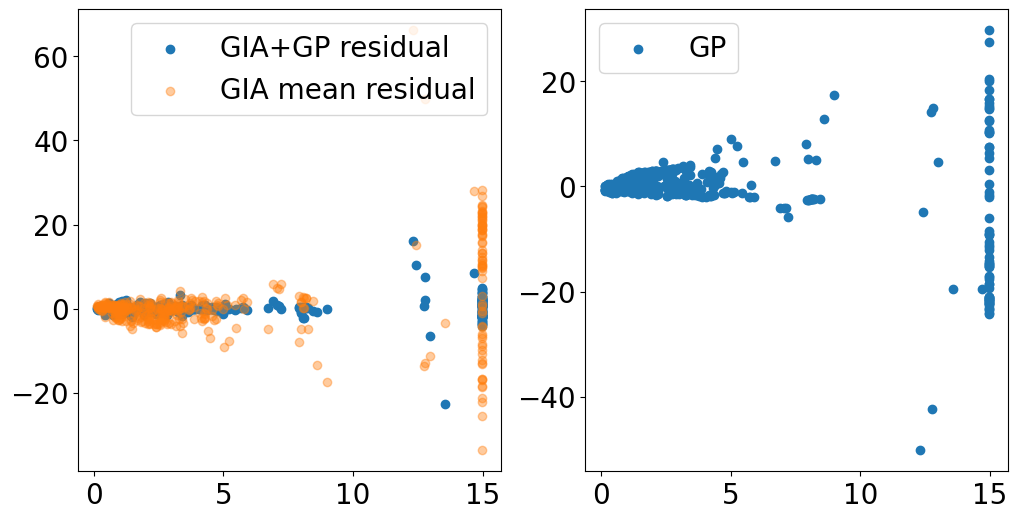

In [ ]:
test_mean,test_cov = gpr(SLIP_X_all)
GIA_test_mean = gpr.mean_function(SLIP_X_all)
plt.subplot(121)
plt.scatter(SLIP_X_all[:,0],(test_mean-SLIP_y).detach().numpy(),label='GIA+GP residual')
plt.scatter(SLIP_X_all[:,0],(GIA_test_mean-SLIP_y).detach().numpy(),alpha=0.4,label='GIA mean residual')
plt.legend()

plt.subplot(122)
plt.scatter(SLIP_X_all[:,0],(test_mean-GIA_test_mean).detach().numpy(),label='GP')
plt.legend()

In [ ]:
site_8_index = rsl_data[SLIP_index][:,9]==8
test_age =  np.arange(0,17,0.05)
X_all_test = torch.tensor(SLIP_X_all[site_8_index])

pred_matrix = PSTHM.gen_pred_matrix(test_age,np.mean(X_all_test[:,1].detach().numpy()),np.mean(X_all_test[:,2].detach().numpy()))
y_mean, y_var = gpr(pred_matrix.double(), full_cov=True)
y_std = y_var.diag().sqrt()
mean_GIA = gpr.mean_function(pred_matrix)

y_mean2, y_var2 = gpr(SLIP_X_all[site_8_index].double(), full_cov=True)
y_std2 = y_var2.diag().sqrt()

mean_GIA2 = gpr.mean_function(SLIP_X_all[site_8_index].double())


<ErrorbarContainer object of 3 artists>

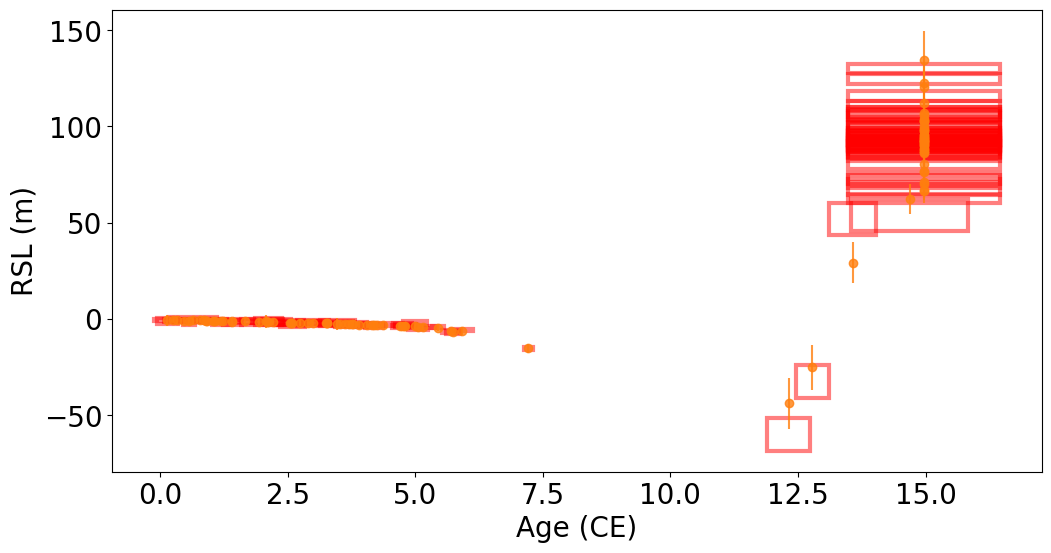

In [ ]:
PSTHM.plot_uncertainty_boxes(X_all[:,0][SLIP_index][site_8_index], y[SLIP_index][site_8_index],
             SLIP_age_sigma[site_8_index]*2,SLIP_y_sigma[site_8_index]*2)

# plt.plot(test_age,y_mean.detach().numpy(), color='C1')
# plt.plot(test_age,mean_GIA.detach().numpy(), color='C3')
# plt.fill_between(test_age, y_mean.detach().numpy()-2*y_std.detach().numpy(), y_mean.detach().numpy()+2*y_std.detach().numpy(), color='C1', alpha=0.2)
plt.errorbar(SLIP_X_all[site_8_index][:,0],y_mean2.detach().numpy(),yerr=2*y_std2.detach().numpy()*2,fmt='o',color='C1',zorder=10,alpha=0.8)
# plt.scatter(SLIP_X_all[site_8_index][:,0]-0.5,mean_GIA2.detach().numpy(),color='C2',zorder=10,alpha=0.8)
# plt.scatter(SLIP_X_all[site_8_index][:,0],(y_mean2-mean_GIA2).detach().numpy(),color='C4',zorder=10,alpha=0.8)

In [ ]:
lat_matrix = np.arange(40,47,0.1)
lon_matrix = np.arange(285,300,0.25)
#Change the number here to visulize RSL at different time!!
time_mat = np.array([14.97]) 
#---------------------------------------------------------------------
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()

std_mask = (y_std).abs()>10
masked_y_mean = np.ma.array(y_mean.detach().numpy(),mask=std_mask).reshape([70,60])
masked_GIA_mean = np.ma.array(gpr.mean_function(pred_matrix).detach().numpy(),mask=std_mask).reshape([70,60])

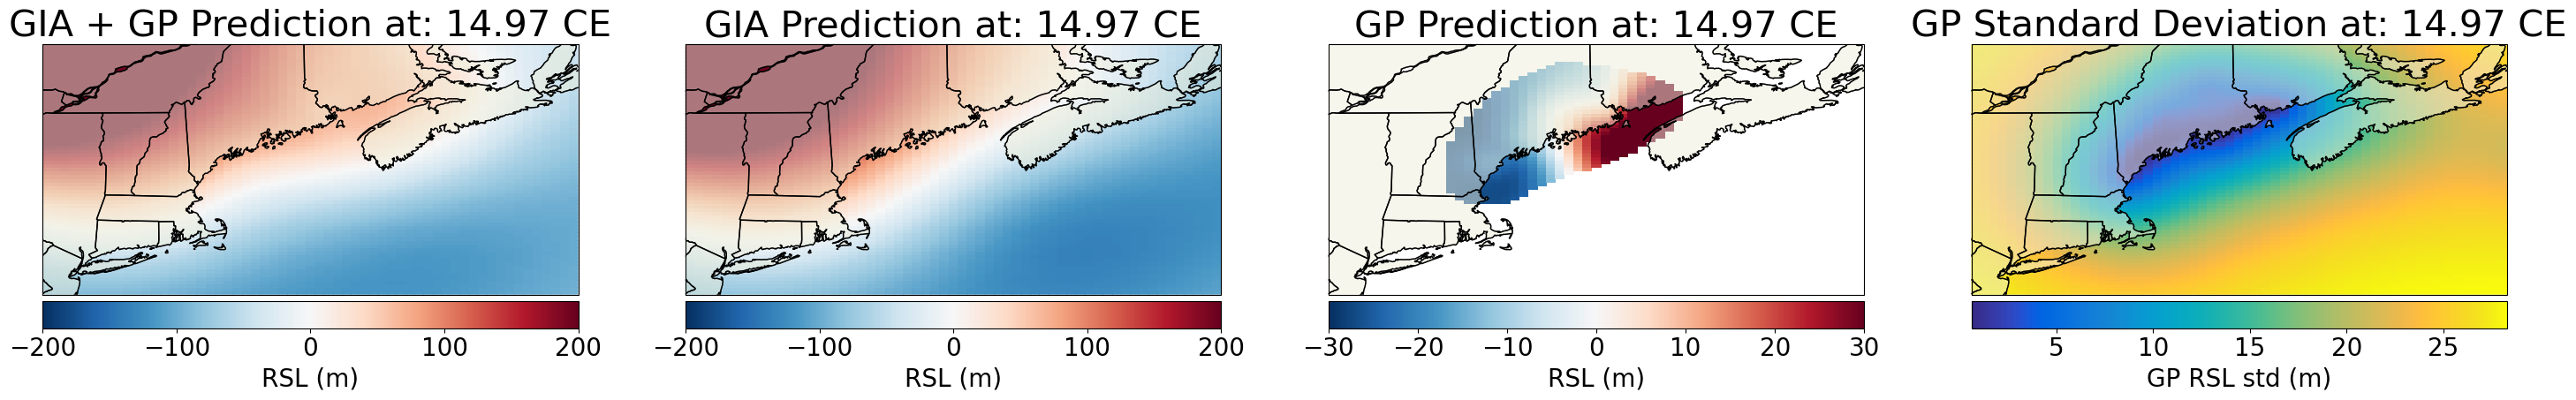

In [ ]:
age_index = SLIP_X_all[:,0]>14

#------------plot -----------------
fig = plt.figure(figsize=(36,10))
ax2 = plt.subplot(141,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_mean.detach().numpy().reshape([70,60]),transform=ccrs.PlateCarree(),cmap='RdBu_r',zorder=0,
                    vmax=200,vmin=-200)
# ax2.scatter(SLIP_X_all[:,2].detach().numpy()[site_8_index][age_index],SLIP_X_all[:,1].detach().numpy()[site_8_index][age_index],
#             c='red',s=100,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA + GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(142,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,gpr.mean_function(pred_matrix).detach().numpy().reshape([70,60]),transform=ccrs.PlateCarree(),cmap='RdBu_r',zorder=0,
                vmax=200,vmin=-200)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(143,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,masked_y_mean-masked_GIA_mean,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=30,vmin=-30,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
# ax2.scatter(SLIP_X_all[:,2].detach().numpy()[age_index],SLIP_X_all[:,1].detach().numpy()[age_index],
#             c='None',s=50,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2,alpha=0.5)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)


ax2 = plt.subplot(144,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_std.detach().numpy().reshape([70,60]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
cbar.set_label('GP RSL std (m)')
ax2.set_title('GP Standard Deviation at: {:} CE'.format(time_mat[0]),fontsize=30);

In [ ]:
lat_matrix = np.arange(40,47,0.1)
lon_matrix = np.arange(285,300,0.25)
#Change the number here to visulize RSL at different time!!
time_mat = np.array([12.5]) 
#---------------------------------------------------------------------
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()


std_mask = (y_std).abs()>10
masked_y_mean = np.ma.array(y_mean.detach().numpy(),mask=std_mask).reshape([70,60])
masked_GIA_mean = np.ma.array(gpr.mean_function(pred_matrix).detach().numpy(),mask=std_mask).reshape([70,60])

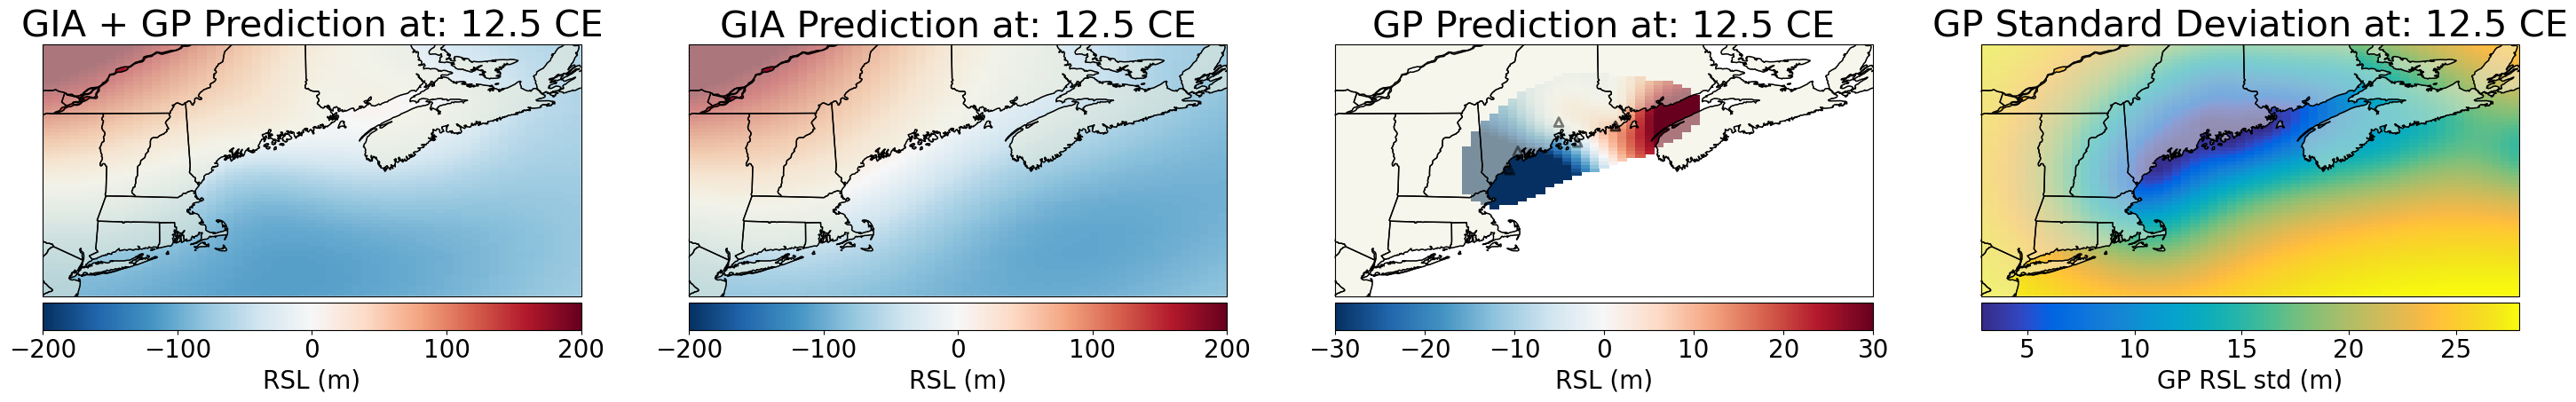

In [ ]:
age_index = (SLIP_X_all[:,0]<14)&(SLIP_X_all[:,0]>12)

#------------plot -----------------
fig = plt.figure(figsize=(36,10))
ax2 = plt.subplot(141,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_mean.detach().numpy().reshape([70,60]),transform=ccrs.PlateCarree(),cmap='RdBu_r',zorder=0,
                    vmax=200,vmin=-200)
# ax2.scatter(SLIP_X_all[:,2].detach().numpy()[site_8_index][age_index],SLIP_X_all[:,1].detach().numpy()[site_8_index][age_index],
#             c='red',s=100,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA + GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(142,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,gpr.mean_function(pred_matrix).detach().numpy().reshape([70,60]),transform=ccrs.PlateCarree(),cmap='RdBu_r',zorder=0,
                vmax=200,vmin=-200)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
cbar.set_label('RSL (m)')
ax2.set_title('GIA Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

ax2 = plt.subplot(143,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,masked_y_mean-masked_GIA_mean,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=30,vmin=-30,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
ax2.scatter(SLIP_X_all[:,2].detach().numpy()[age_index],SLIP_X_all[:,1].detach().numpy()[age_index],
            c='None',s=50,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2,alpha=0.5)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)


ax2 = plt.subplot(144,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,y_std.detach().numpy().reshape([70,60]),transform=ccrs.PlateCarree(),cmap=parula,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
cbar.set_label('GP RSL std (m)')
ax2.set_title('GP Standard Deviation at: {:} CE'.format(time_mat[0]),fontsize=30);


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


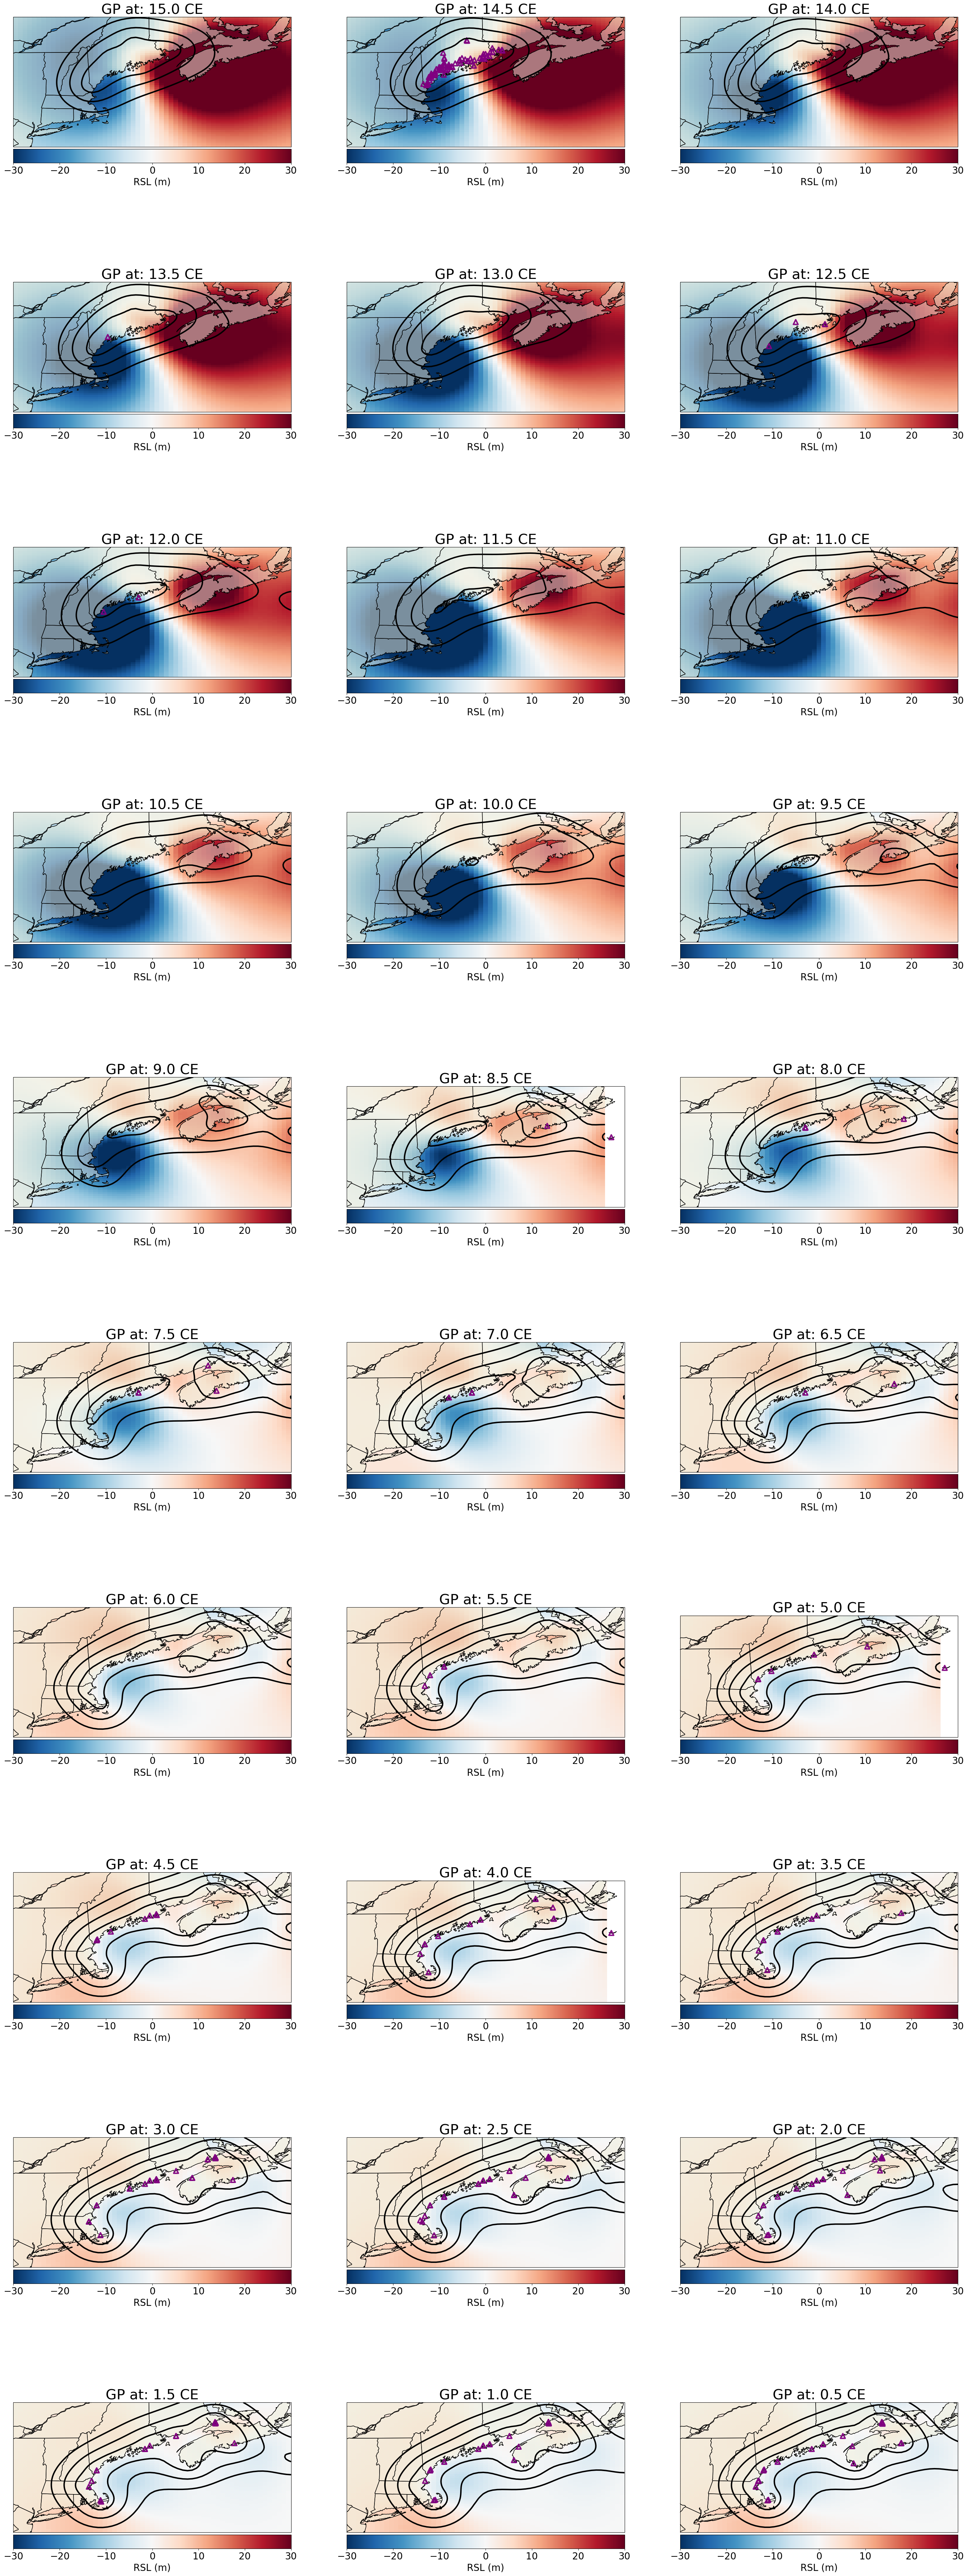

In [ ]:
fig = plt.figure(figsize=(36,100))
lat_matrix = np.arange(40,47,0.1)
lon_matrix = np.arange(285,300,0.25)
test_time = np.arange(15,0,-0.5)

for i in range(len(test_time)):
    print(i)
    pred_matrix = PSTHM.gen_pred_matrix(test_time[i],lat_matrix,lon_matrix)
    y_mean, y_var = gpr(pred_matrix, full_cov=True)
    y_std = y_var.diag().sqrt()
    y_mean =y_mean.detach().numpy().reshape([70,60])
    GIA_mean =gpr.mean_function(pred_matrix).detach().numpy().reshape([70,60])
    age_index = (SLIP_X_all[:,0]<(test_time[i]+0.5))&(SLIP_X_all[:,0]>test_time[i])


    ax2 = plt.subplot(10,3,i+1,projection=ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
    ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
    cax = ax2.pcolor(lon_mat,lat_mat,y_mean-GIA_mean,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=30,vmin=-30,zorder=0)
    cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
    ax2.scatter(SLIP_X_all[:,2].detach().numpy()[age_index],SLIP_X_all[:,1].detach().numpy()[age_index],
                c='None',s=100,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='purple',linewidth=3,alpha=0.95)
    cax = ax2.contour(lon_mat,lat_mat,y_std.detach().numpy().reshape([70,60]),[5,10,15],transform=ccrs.PlateCarree(),colors=['k'],zorder=110,linewidths=3)

    cbar.set_label('RSL (m)')
    ax2.set_title('GP at: {:} CE'.format(test_time[i]),fontsize=30)


### Including Limiting Data

In [2]:
rsl_data = np.loadtxt('Maine_RSL/MaineBarilsiteall.dat')
x = rsl_data[:,2]
y = rsl_data[:,5]
lat = rsl_data[:,0]
lon = rsl_data[:,1]
x_sigma = (rsl_data[:,3]+rsl_data[:,4])/4
y_sigma = (rsl_data[:,6]+rsl_data[:,7])/4
ind = rsl_data[:,8]

sort_index = np.argsort(x)
x = x[sort_index]
y = y[sort_index]
lat = lat[sort_index]
lon = lon[sort_index]
y_sigma = y_sigma[sort_index]
x_sigma = x_sigma[sort_index]
ind = ind[sort_index]

SLIP_index = ind==0
TL_index = ind==1
ML_index = ind==-1


SLIP_X = x[SLIP_index]
SLIP_y = y[SLIP_index]
SLIP_x_sigma = x_sigma[SLIP_index]
SLIP_y_sigma = y_sigma[SLIP_index]

TL_X = x[TL_index]
TL_y = y[TL_index]
TL_x_sigma = x_sigma[TL_index]
TL_y_sigma = y_sigma[TL_index]

ML_X = x[ML_index]
ML_y = y[ML_index]
ML_x_sigma = x_sigma[ML_index]
ML_y_sigma = y_sigma[ML_index]


X_all = np.vstack([x,lat,lon]).T 

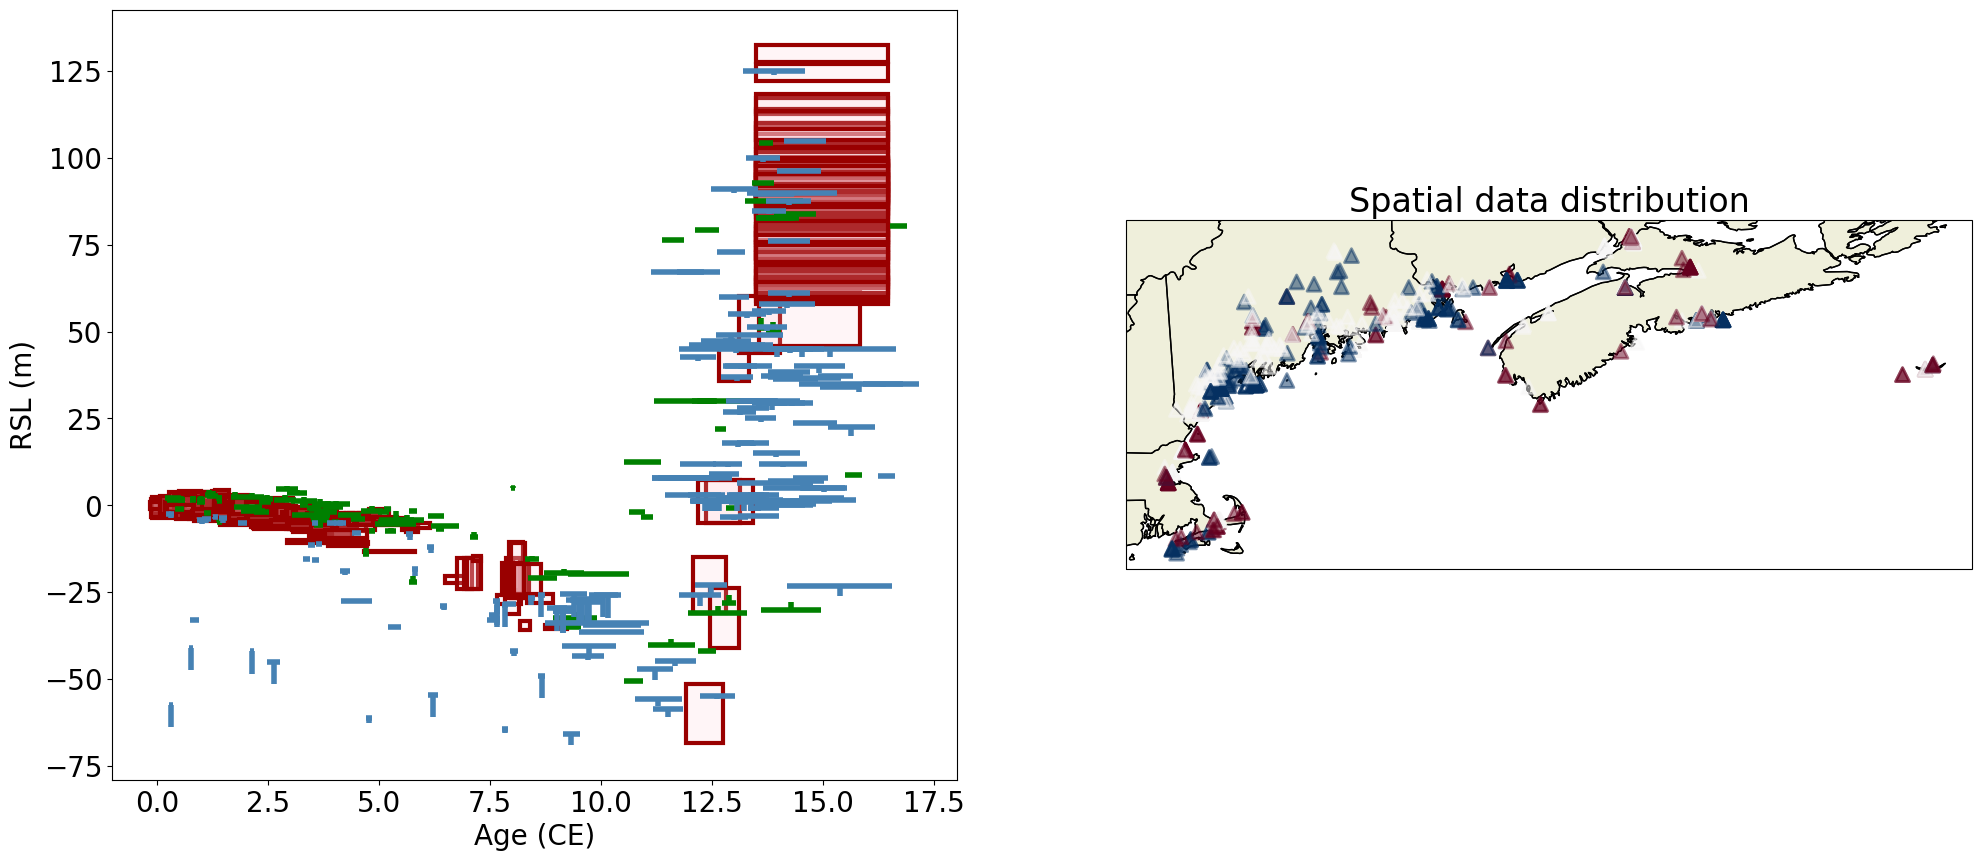

In [3]:
fig = plt.figure(figsize=(24,10))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0, :1])
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2,ax=ax)
plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4);

#plot spatial data distribution, note that the size of the circle is proportional to the number of data points in the region
ax2 = fig.add_subplot(gs[0, 1:2], projection=ccrs.PlateCarree())

ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
ax2.scatter(X_all[:,2],X_all[:,1],c=ind,s=100,cmap='RdBu_r',transform=ccrs.PlateCarree(),zorder=20,marker='^',linewidth=2,alpha=0.5)
ax2.set_title('Spatial data distribution');

In [4]:
import scipy.io
GIA_1 = scipy.io.loadmat('Maine_RSL/ice6g_72p515_RSL.mat')
GIA_2 = scipy.io.loadmat('Maine_RSL/ice6g_96p515_RSL.mat')
GIA_3 = scipy.io.loadmat('Maine_RSL/ice6g_vm2_RSL.mat')
coor = scipy.io.loadmat('Maine_RSL/LONLAT256.mat')
from scipy.interpolate import RegularGridInterpolator as rgi
W_lon =coor['LON'][0,:]
W_lon[W_lon<0]+=360
GIA_1_interp = rgi((GIA_3['time'][25:,0][::-1],coor['LAT'][:,0][::-1],coor['LON'][0,:]), np.array([*GIA_1['RSL'][:,0][25:]])[::-1,::-1])
GIA_2_interp = rgi((GIA_3['time'][25:,0][::-1],coor['LAT'][:,0][::-1],coor['LON'][0,:]), np.array([*GIA_2['RSL'][:,0][25:]])[::-1,::-1])
GIA_3_interp = rgi((GIA_3['time'][25:,0][::-1],coor['LAT'][:,0][::-1],coor['LON'][0,:]), np.array([*GIA_3['RSL'][:,0][25:]])[::-1,::-1])
#transfer longitude from -180-180 to 0-360
X_new = torch.clone(torch.tensor(X_all))
X_new[:,2]+=360
GIA_1_pred = GIA_1_interp(X_new)
GIA_2_pred = GIA_2_interp(X_new)
GIA_3_pred = GIA_3_interp(X_new)

  0%|          | 0/300 [00:00<?, ?it/s]

Execution time: 12.086 s


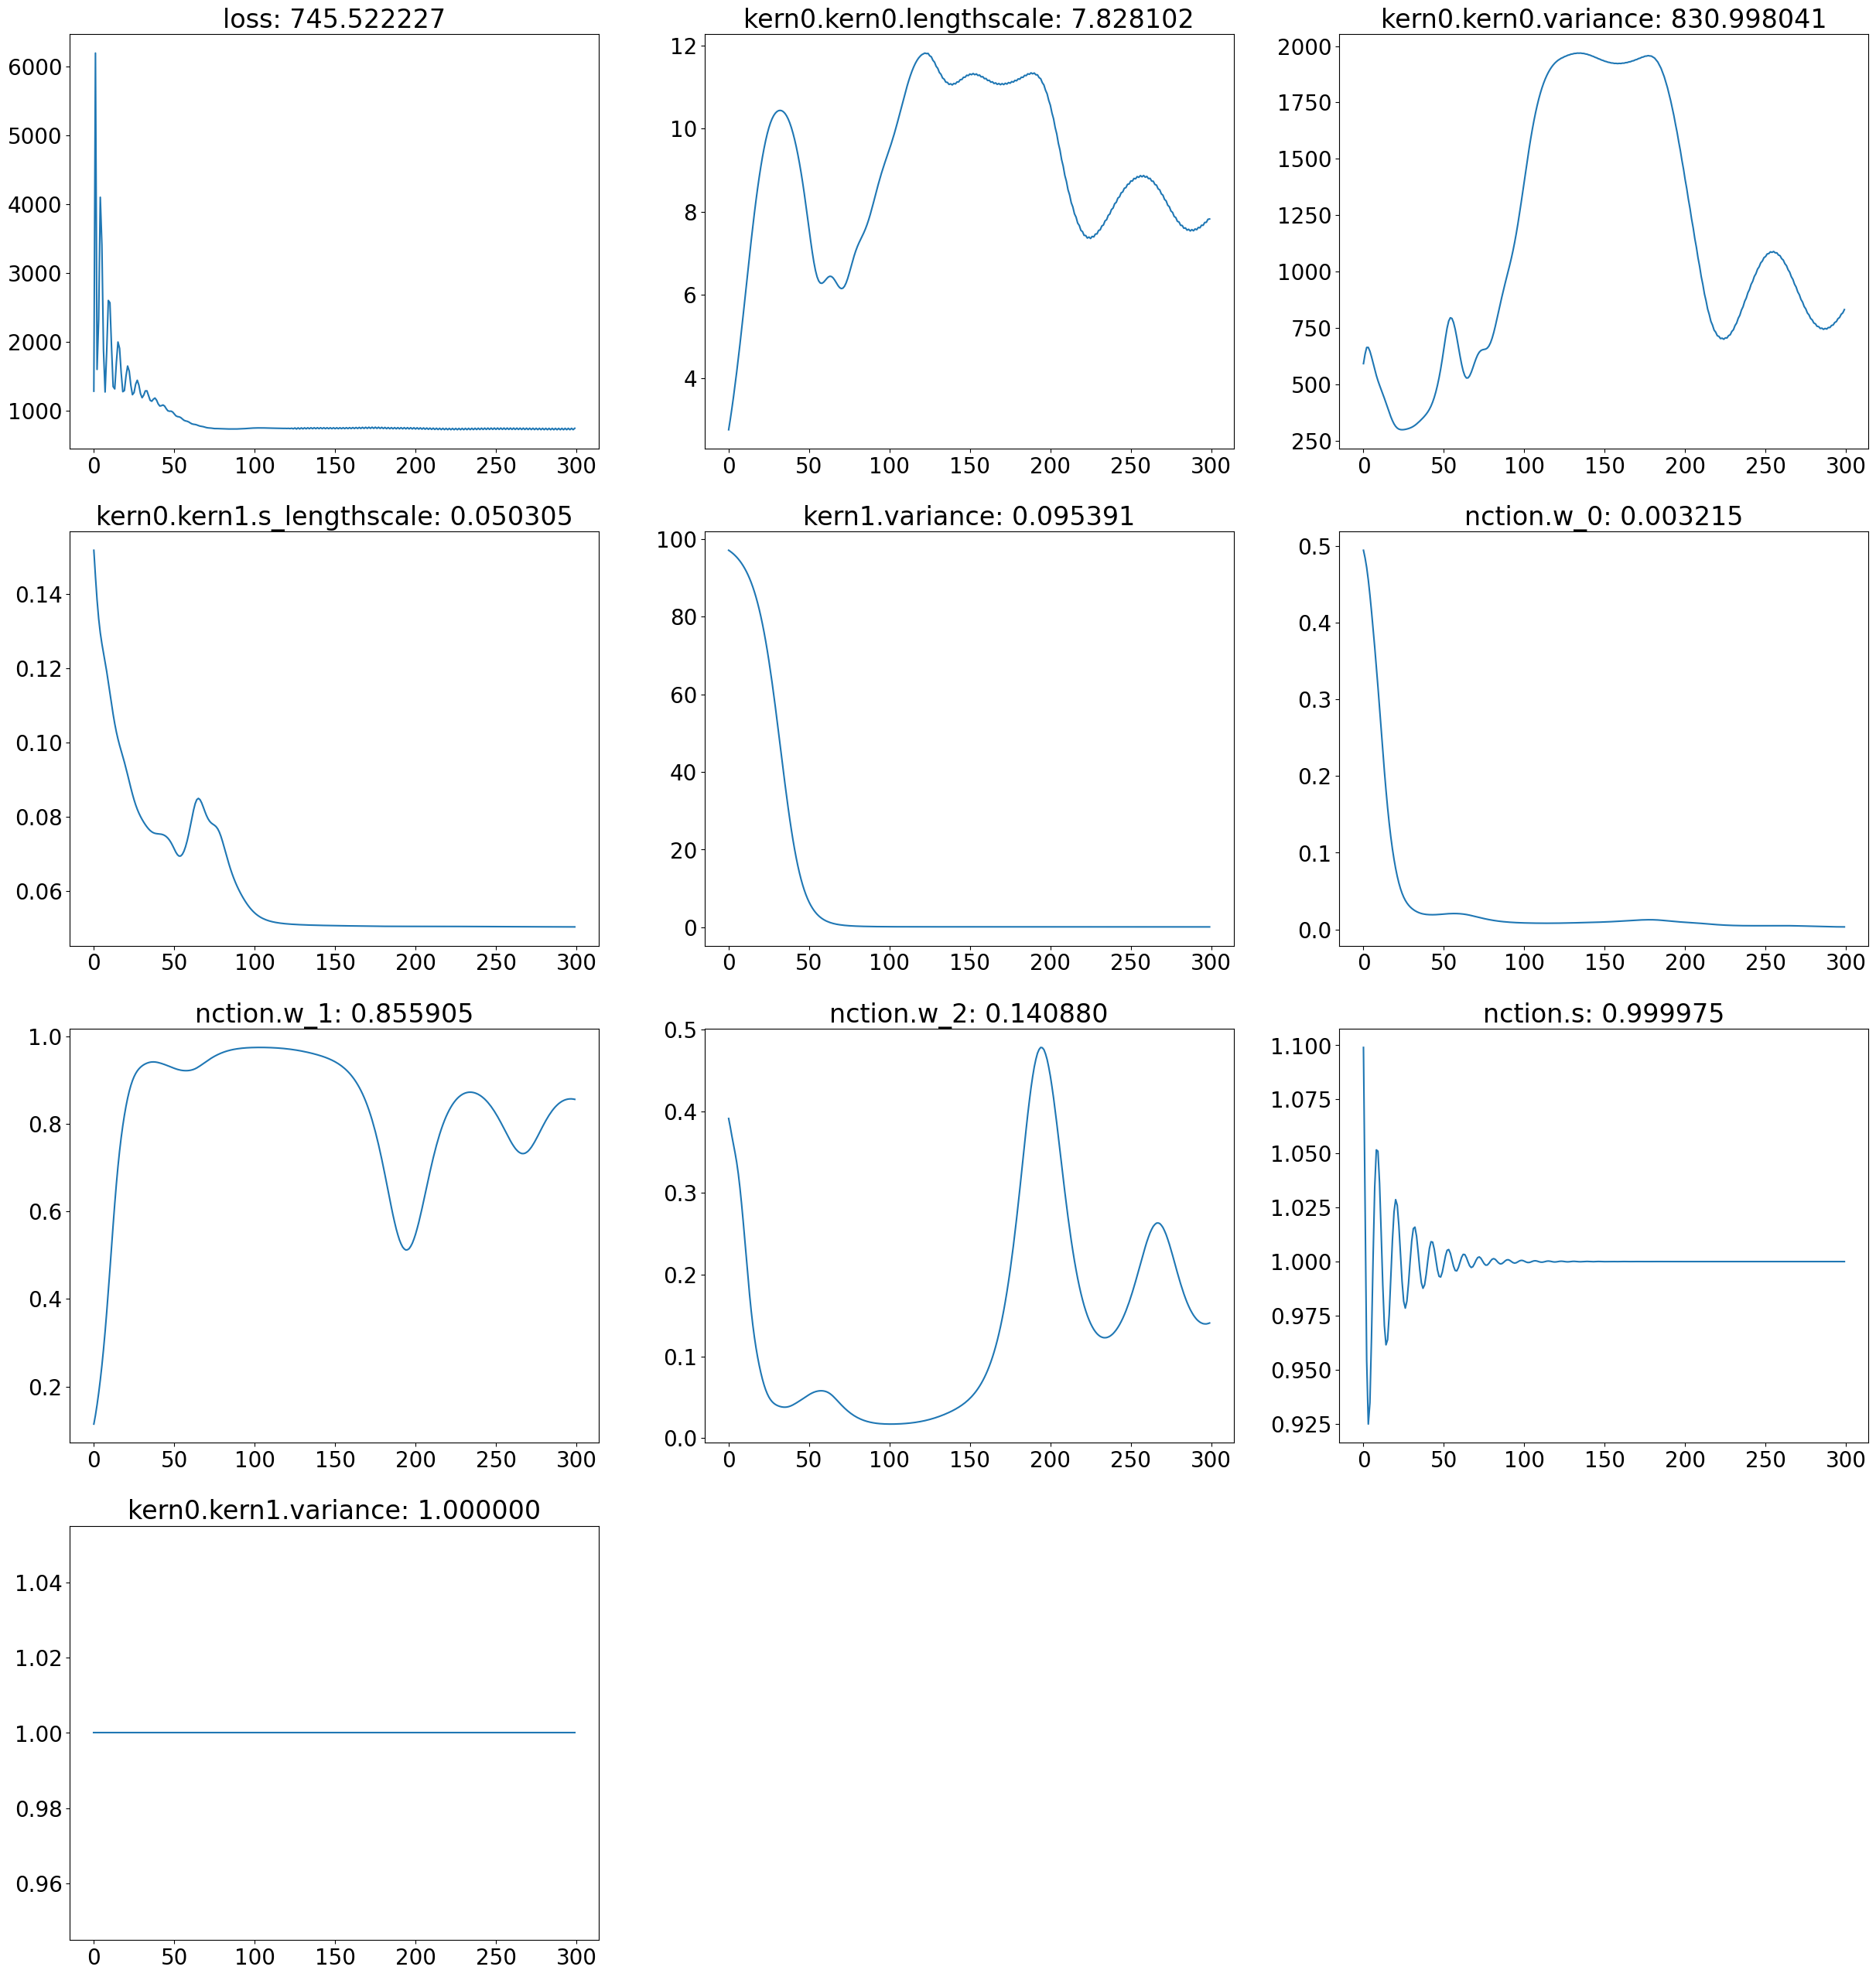

In [5]:
SLIP_X_all = torch.tensor(X_new[SLIP_index])
SLIP_y = torch.tensor(y[SLIP_index])
SLIP_age_sigma = torch.tensor(x_sigma[SLIP_index])
SLIP_y_sigma = torch.tensor(y_sigma[SLIP_index])
st = time.time() 

pyro.clear_param_store()

#define locally non-linar spatio-temporal kernel
local_nl__temporal_kernel = PSTHM.Matern32(input_dim=1,geo=False)
local_nl__temporal_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(20.)))
local_nl__temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5**2), torch.tensor(50.**2)))
local_nl__spatial_kernel = PSTHM.Matern32(input_dim=1,geo=True)
local_nl__spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.05), torch.tensor(0.4)))
local_nl_kernel = gp.kernels.Product(local_nl__temporal_kernel, local_nl__spatial_kernel)

#define whitenoise kernel
whitenoise_kernel = gp.kernels.WhiteNoise(input_dim=1)
whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(0.1**2),torch.tensor(100.)))

#combine all kernels
combined_sp_kernel = gp.kernels.Sum(local_nl_kernel,whitenoise_kernel)

#----define mean function
# the first number (2) here means there are 2 GIA models to interpolate
mean_fn = PSTHM.GIA_ensemble([GIA_1_interp,GIA_2_interp,GIA_3_interp])
mean_fn.set_prior('w',dist.Dirichlet(torch.ones(3)))
mean_fn.set_prior('s',dist.Normal(torch.tensor(1.0),torch.tensor(0.001)))

gpr = PSTHM.GPRegression_V(SLIP_X_all, SLIP_y, combined_sp_kernel,noise=torch.tensor(SLIP_y_sigma**2),jitter=1e-5,mean_function=mean_fn)

#Empirical bayes optimization, default iteration is 1000
gpr,track_list = PSTHM.SVI_NI_optm(gpr,x_sigma=SLIP_age_sigma,num_iteration=300,lr=0.1,decay_r = 1,step_size=50)
axes = PSTHM.plot_track_list(track_list)

#calulate log likelihood of the model prediction

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
print('Execution time: {:3.3f} s'.format( elapsed_time))


In [6]:
test_ind = ind.copy()
while True:
    test_pred,test_cov = gpr(torch.tensor(X_new))
    test_pred = test_pred.detach().numpy()
    test_std = test_cov.sqrt().detach().numpy()
    index = ((test_pred >y) & (test_ind==1))  | ((test_pred <y) & (test_ind==-1))
    test_ind[index] = 0
    if np.sum(index) == 0:
        break
    gpr.X = torch.tensor(X_new[test_ind==0])    
    gpr.y = torch.tensor(y[test_ind==0])
    gpr.noise = torch.tensor(y_sigma[test_ind==0]**2)

vio_TL_index = (test_pred >y) & (TL_index==1)
vio_ML_index = (test_pred <y) & (ML_index==1)
test_pred[vio_TL_index] = y[vio_TL_index] - 2*y_sigma[vio_TL_index]
test_pred[vio_ML_index] = y[vio_ML_index] + 2*y_sigma[vio_ML_index]

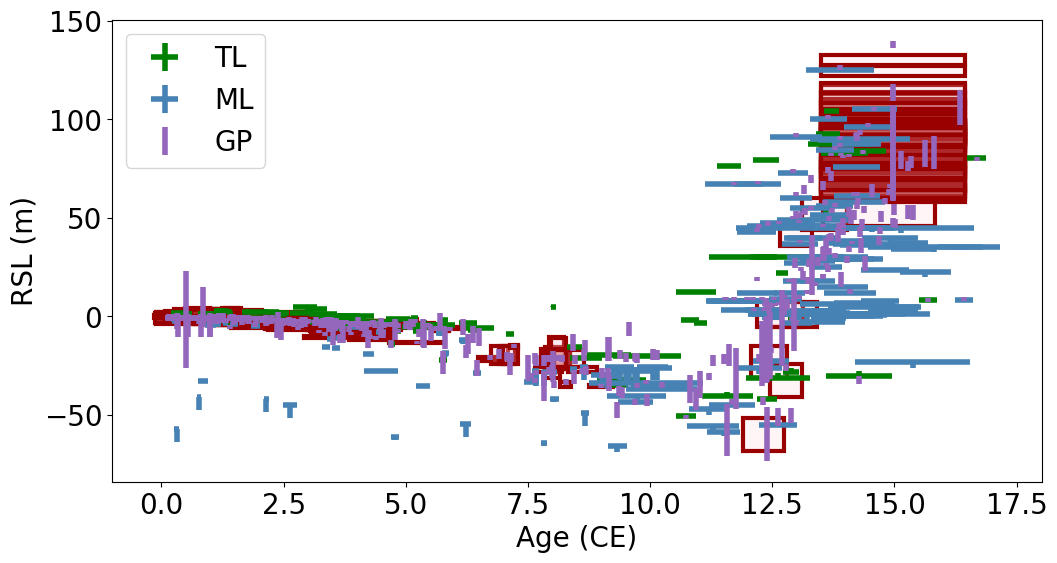

In [8]:
PSTHM.plot_uncertainty_boxes(SLIP_X,SLIP_y,SLIP_x_sigma*2,SLIP_y_sigma*2)

plt.errorbar(TL_X,TL_y,xerr=TL_x_sigma,yerr=[[0]*len(TL_X),2*TL_y_sigma],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(ML_X,ML_y,xerr=ML_x_sigma,yerr=[2*ML_y_sigma,[0]*len(ML_X)],fmt='None',color='steelblue',label='ML',linewidth=4)
plt.errorbar(x,test_pred,yerr = test_cov.sqrt().detach().numpy()*2,fmt='None',color='C4',label='GP',linewidth=4)
plt.legend()

In [10]:
def cal_limiting_log_likelihood(prop_y,y,y_sigma,limiting_type):
    '''A function to calulate log likelihood for limiting data that combines each datum's 
    normally-distributed measurement uncertainty and stepwise indicative meaning 
    
    
    ----------Inputs-----------
    prop_y: the proposed new y value
    y: observed elevation value
    y_sigma: the measurement uncertainty of y
    limiting_type: the type of limiting data, 1 for terrestrial limiting, -1 for marine limiting
    '''

    limiting_log_likelihood = 0
    if limiting_type == 1:
        fit_index = prop_y < y
        limiting_log_likelihood +=np.log(np.e)*(fit_index.sum())
        if fit_index.sum()<len(y):
            #multiply by 2 because the elevation uncertainty is assumed to be truncated normal distribution,
            # which is truncated from to 0 to inf
            limiting_log_likelihood += np.log(stats.norm(y[~fit_index],y_sigma[~fit_index]).pdf(prop_y[~fit_index])*2).sum()
    elif limiting_type == -1:
        fit_index = prop_y > y
        limiting_log_likelihood +=np.log(np.e)*(fit_index.sum())

        if fit_index.sum()<len(y):
            #multiply by 2 because the elevation uncertainty is assumed to be truncated normal distribution,
            # which is truncated from to -inf to 0
            limiting_log_likelihood += np.log(stats.norm(y[~fit_index],y_sigma[~fit_index]).pdf(prop_y[~fit_index])*2).sum()
    return limiting_log_likelihood


def cal_limiting_log_likelihood2(prop_y,y,limiting_type):
    '''A function to calulate log likelihood for limiting data that combines each datum's 
    normally-distributed measurement uncertainty and stepwise indicative meaning 
    
    ----------Inputs-----------
    prop_y: the proposed new y value
    y: observed elevation value
    limiting_type: the type of limiting data, 1 for terrestrial limiting, -1 for marine limiting
    '''

    limiting_log_likelihood = 0
    if limiting_type == 1:
        limiting_log_likelihood += np.log((prop_y < y)+1e-5).sum() 

    elif limiting_type == -1:
        fit_index = prop_y > y
        limiting_log_likelihood +np.log((prop_y > y)+1e-5).sum() 

    return limiting_log_likelihood

In [154]:
import scipy.stats as stats
from tqdm.notebook import tqdm

np.random.seed(1358)
#-----------create store for posterior samples----------------
sample_size = 20000
burn_in =0
total_size = sample_size+burn_in
post_x = np.zeros((sample_size,len(X_new)))
post_y = np.zeros((sample_size,len(y)))
post_length = np.zeros((sample_size,1))
post_s_length = np.zeros((sample_size,1))
post_variance = np.zeros((sample_size,1))
post_noise = np.zeros((sample_size,1))
post_w = np.zeros((sample_size,3))
post_log_likelihood = np.zeros((sample_size,1))
post_limiting = np.zeros((sample_size,len(x)))

#-----------Set initial values----------------
y_store = test_pred.copy()
x_store = X_new.detach().numpy().copy()
test_x = x_store[:,0] + np.random.normal(0,x_sigma)
test_x[test_x<0] = 1e-5
x_store[:,0] = test_x
random_y = y.copy() #this variance is used to sample random elevation uncertainty of limiting data
length_store = track_list['kern0.kern0.lengthscale'].iloc[-1]
variance_store = track_list['kern0.kern0.variance'].iloc[-1]
s_length_store = track_list['kern0.kern1.s_lengthscale'].iloc[-1]
noise_store = track_list['kern1.variance'].iloc[-1]
w_store = np.array([0.000066,0.998727,0.001207])
gpr.noise = torch.tensor(y_sigma**2)*0
acc_log_likelihood = -1e5
gpr.X = torch.tensor(x_store)
gpr.y = torch.tensor(y_store)

#-----------Start MCMC----------------
for nn in tqdm(range(5000)):
    resi_y = y_store - gpr.mean_function(torch.tensor(x_store)).detach().numpy()
    obs_resi_y = y - gpr.mean_function(torch.tensor(x_store)).detach().numpy()
    gpr.X = torch.tensor(x_store)
    gpr.y = torch.tensor(y_store)
    all_cov = gpr.kernel(torch.tensor(x_store)).detach().numpy()
    
    for i in range(len(x)):
            
        test_cov = np.delete(all_cov,i,axis=0)
        test_cov = np.delete(test_cov,i,axis=1)
        test_cov_single = np.delete(all_cov[i:i+1],i)
        
        Kt_K = test_cov_single @  np.linalg.inv(test_cov)
        GP_y = Kt_K @ np.delete(resi_y,i)
        GP_var = all_cov[i,i] - Kt_K @ test_cov_single.T

        if ind[i] ==0:
            prop_y = np.average([GP_y,obs_resi_y[i]],weights=[1/GP_var,1/y_sigma[i]**2])
            prop_var = np.average([GP_var,y_sigma[i]**2],weights=[1/GP_var,1/y_sigma[i]**2])
        else:
            prop_y,prop_var = GP_y,GP_var

        #-------update y --------------------
        prop_std = np.sqrt(prop_var+1e-4) #add a small number to avoid nan
        test_y = prop_y +  np.random.normal(0,prop_std)
        
        if ind[i] ==0:
            resi_y[i] = test_y
        
        elif ind[i]==1:
            if test_y < (random_y[i]-obs_resi_y[i]):
                resi_y[i] = test_y
                random_y[i] = np.random.normal(y[i],y_sigma[i])

        elif ind[i]==-1:
            if test_y > (random_y[i]-obs_resi_y[i]):
                resi_y[i] = test_y
                random_y[i] = np.random.normal(y[i],y_sigma[i])
        
    # get the execution time
    y_store = resi_y + gpr.mean_function(torch.tensor(x_store)).detach().numpy()
    #-------update age --------------------
    random_TL_y = random_y[TL_index]
    random_ML_y = random_y[ML_index]
    prop_x = np.random.normal(X_new[:,0],x_sigma)
    prop_x[prop_x<0] = 1e-5
    x_store[:,0] = prop_x
    #-------update hyperparameters after burn-in iteration------
    
    
    #-------update length scale--------------------------------
    ori_y,_ = gpr(torch.tensor(x_store))
    ori_y = ori_y.detach().numpy()
    ori_SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(ori_y[SLIP_index]))
    ori_SLIP_log_likelihood[ori_SLIP_log_likelihood<-50]=-50 #avoid nan
    ori_SLIP_log_likelihood = ori_SLIP_log_likelihood.sum()
    ori_TL_log_likelihood = cal_limiting_log_likelihood2(ori_y[TL_index],random_TL_y,1)
    ori_ML_log_likelihood = cal_limiting_log_likelihood2(ori_y[ML_index],random_ML_y,-1)    
    ori_prop_log_likelihood = ori_SLIP_log_likelihood + ori_TL_log_likelihood + ori_ML_log_likelihood
    
    prop_length = np.random.normal(length_store,1)
    if prop_length<2.5: prop_length=2.5
    elif prop_length>20.: prop_length=20.
    gpr.kernel.kern0.kern0.lengthscale= torch.tensor(prop_length)

    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()
    
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - ori_prop_log_likelihood)
    y_acc_prob = np.min([1,y_prob])

    if np.random.rand() < y_acc_prob:
        ori_prop_log_likelihood = prop_log_likelihood
        length_store = prop_length


    else:
        gpr.kernel.kern0.kern0.lengthscale = torch.tensor(length_store)

    #-------update variance--------------------------------
    prop_variance = np.random.normal(variance_store,100)
    if prop_variance<500: prop_variance = 500.
    elif prop_variance>3000: prop_variance = 3000.
    gpr.kernel.kern0.kern0.variance = torch.tensor(prop_variance)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()
    
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - ori_prop_log_likelihood)
    y_acc_prob = np.min([1,y_prob])
    if np.random.rand() < y_acc_prob:
        ori_prop_log_likelihood = prop_log_likelihood
        variance_store = prop_variance

    else:
        gpr.kernel.kern0.kern0.variance = torch.tensor(variance_store)


    #-------update s_lengthscale--------------------------------

    prop_s_length = np.random.normal(s_length_store,0.1)
    if prop_s_length<0.01: prop_s_length = 0.01
    elif prop_s_length>0.4: prop_s_length = 0.4
    gpr.kernel.kern0.kern1.s_lengthscale= torch.tensor(prop_s_length)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()
    
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - ori_prop_log_likelihood)
    y_acc_prob = np.min([1,y_prob])
    if np.random.rand() < y_acc_prob:
        ori_prop_log_likelihood = prop_log_likelihood
        s_length_store = prop_s_length

    else:
        gpr.kernel.kern0.kern1.s_lengthscale = torch.tensor(s_length_store)

    #-------update w--------------------------------
    w_prop = np.random.normal(np.zeros(3),[0.1,0.1,0.1])
    w_prop[2] = np.sum(w_prop[:2])*-1
    w_prop = w_store + w_prop
    w_prop[w_prop<0] = 0
    w_prop = w_prop/np.sum(w_prop)
    gpr.mean_function.w = torch.tensor(w_prop)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()
    
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - ori_prop_log_likelihood)
    y_acc_prob = np.min([1,y_prob])
    if np.random.rand() < y_acc_prob:
        ori_prop_log_likelihood = prop_log_likelihood
        w_store = w_prop

    else:

        gpr.mean_function.w = torch.tensor(w_store)

    #-------update noise--------------------------------
    prop_noise = np.random.normal(noise_store,0.01)
    if prop_noise>1: prop_noise = 1.
    elif prop_noise<1e-4: prop_noise = 1e-4
    gpr.kernel.kern1.variance = torch.tensor(prop_noise)
    prop_y,_ = gpr(torch.tensor(x_store))
    prop_y = prop_y.detach().numpy()
    
    SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(prop_y[SLIP_index]))
    SLIP_log_likelihood[SLIP_log_likelihood<-50]=-50 #avoid nan
    SLIP_log_likelihood = SLIP_log_likelihood.sum()
    TL_log_likelihood = cal_limiting_log_likelihood2(prop_y[TL_index],random_TL_y,1)
    ML_log_likelihood = cal_limiting_log_likelihood2(prop_y[ML_index],random_ML_y,-1)    
    prop_log_likelihood = SLIP_log_likelihood + TL_log_likelihood + ML_log_likelihood
    
    y_prob = np.exp(prop_log_likelihood - ori_prop_log_likelihood)
    y_acc_prob = np.min([1,y_prob])
    if np.random.rand() < y_acc_prob:
        acc_log_likelihood = prop_log_likelihood
        noise_store = prop_noise


    else:
        gpr.kernel.kern1.variance = torch.tensor(noise_store)
        acc_log_likelihood = ori_prop_log_likelihood

    print(acc_log_likelihood,ori_prop_log_likelihood)
    #---------Store posterior ---------------

    if np.isnan(y_acc_prob): 
        print('Got a problem with likelihood calculation!')
        break 
    if nn< burn_in: continue
    post_x[nn-burn_in] = x_store[:,0]
    post_y[nn-burn_in] = y_store
    post_length[nn-burn_in] = length_store
    post_variance[nn-burn_in] = variance_store
    post_noise[nn-burn_in] = noise_store
    post_w[nn-burn_in] = w_store
    post_s_length[nn-burn_in] = s_length_store
    post_log_likelihood[nn-burn_in] = acc_log_likelihood
    post_limiting[nn-burn_in] = random_y
    if np.isnan(post_y).sum()>0: 
        print('Got a nan value in your posterior values!')
        break

#--------Thinning posterior -------------
#filter out lier
# good_index  = (post_log_likelihood>(np.mean(post_log_likelihood)-np.std(post_log_likelihood)*2))[:,0]
# post_x = post_x[good_index][::10]
# post_y = post_y[good_index][::10]
# post_length = post_length[good_index][::10]
# post_variance = post_variance[good_index][::10]
# post_noise = post_noise[good_index][::10]
# post_log_likelihood = post_log_likelihood[good_index][::10]

  0%|          | 0/5000 [00:00<?, ?it/s]

-1839.9119162622644 -1844.494602316127
-2243.954771543966 -2243.954771543966
-2190.595090503605 -2194.5048288994126
-2348.562061837592 -2346.2789998215453
-2178.0690112129882 -2178.0690112129882
-2695.9584033227056 -2696.013113526553
-2727.2893057155634 -2727.2893057155634
-2516.8011466007492 -2520.2952588328753
-2438.267190899144 -2438.267190899144
-2534.94509869226 -2534.94509869226
-2402.1746993550632 -2402.1746993550632
-2627.5296671186697 -2626.1885085628746


KeyboardInterrupt: 

In [40]:
import scipy.stats as stats

y_store = test_pred.copy()
x_store = X_new.detach().numpy().copy()
# test_x = x_store[:,0] + np.random.normal(0,x_sigma)
# test_x[test_x<0] = 1e-5
# x_store[:,0] = test_x
random_y = y.copy() #this variance is used to sample random elevation uncertainty of limiting data
length_store = track_list['kern0.kern0.lengthscale'].iloc[-1]
variance_store = track_list['kern0.kern0.variance'].iloc[-1]
s_length_store = track_list['kern0.kern1.s_lengthscale'].iloc[-1]
noise_store = track_list['kern1.variance'].iloc[-1]
w_store = np.array([0.000066,0.998727,0.001207])
gpr.noise = torch.tensor(y_sigma**2)*0
acc_log_likelihood = -1e5
gpr.X = torch.tensor(x_store)
gpr.y = torch.tensor(y_store)


#-------update length scale--------------------------------
ori_y,_ = gpr(torch.tensor(x_store))
ori_y = ori_y.detach().numpy()
ori_SLIP_log_likelihood = np.log(stats.norm(SLIP_y,SLIP_y_sigma).pdf(ori_y[SLIP_index]))
ori_SLIP_log_likelihood[ori_SLIP_log_likelihood<-50]=-50 #avoid nan
ori_SLIP_log_likelihood = ori_SLIP_log_likelihood.sum()
ori_TL_log_likelihood = cal_limiting_log_likelihood2(ori_y[TL_index],TL_y,1)
ori_ML_log_likelihood = cal_limiting_log_likelihood2(ori_y[ML_index],ML_y,-1)    
ori_prop_log_likelihood = ori_SLIP_log_likelihood + ori_TL_log_likelihood + ori_ML_log_likelihood
ori_prop_log_likelihood

-975.5866020438997

In [18]:
gpr.X.shape

torch.Size([484, 3])

In [145]:
np.sum(np.abs((resi.detach().numpy()+gpr.mean_function(torch.tensor(x_store)).detach().numpy())[SLIP_index] - SLIP_y.detach().numpy()))

1795.0871140824643

In [76]:
resi = gpr(torch.tensor(x_store))[0] - gpr.mean_function(torch.tensor(x_store))

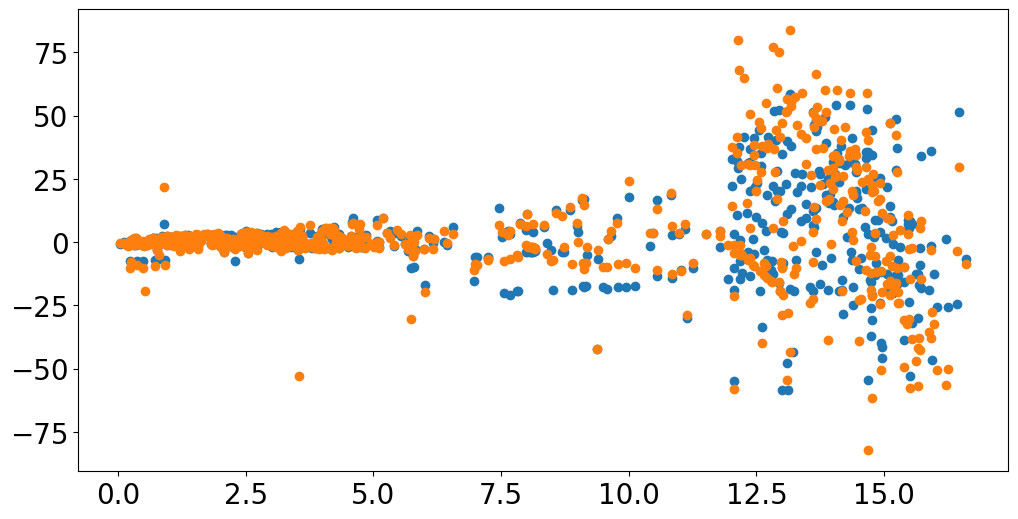

In [146]:
# plt.scatter(x_store[:,0],post_y[0])
# plt.scatter(x_store[:,0],post_y[1])
plt.scatter(x_store[:,0],resi.detach().numpy() )
plt.scatter(x_store[:,0],resi_y)


Text(0.5, 1.0, 'log likelihood')

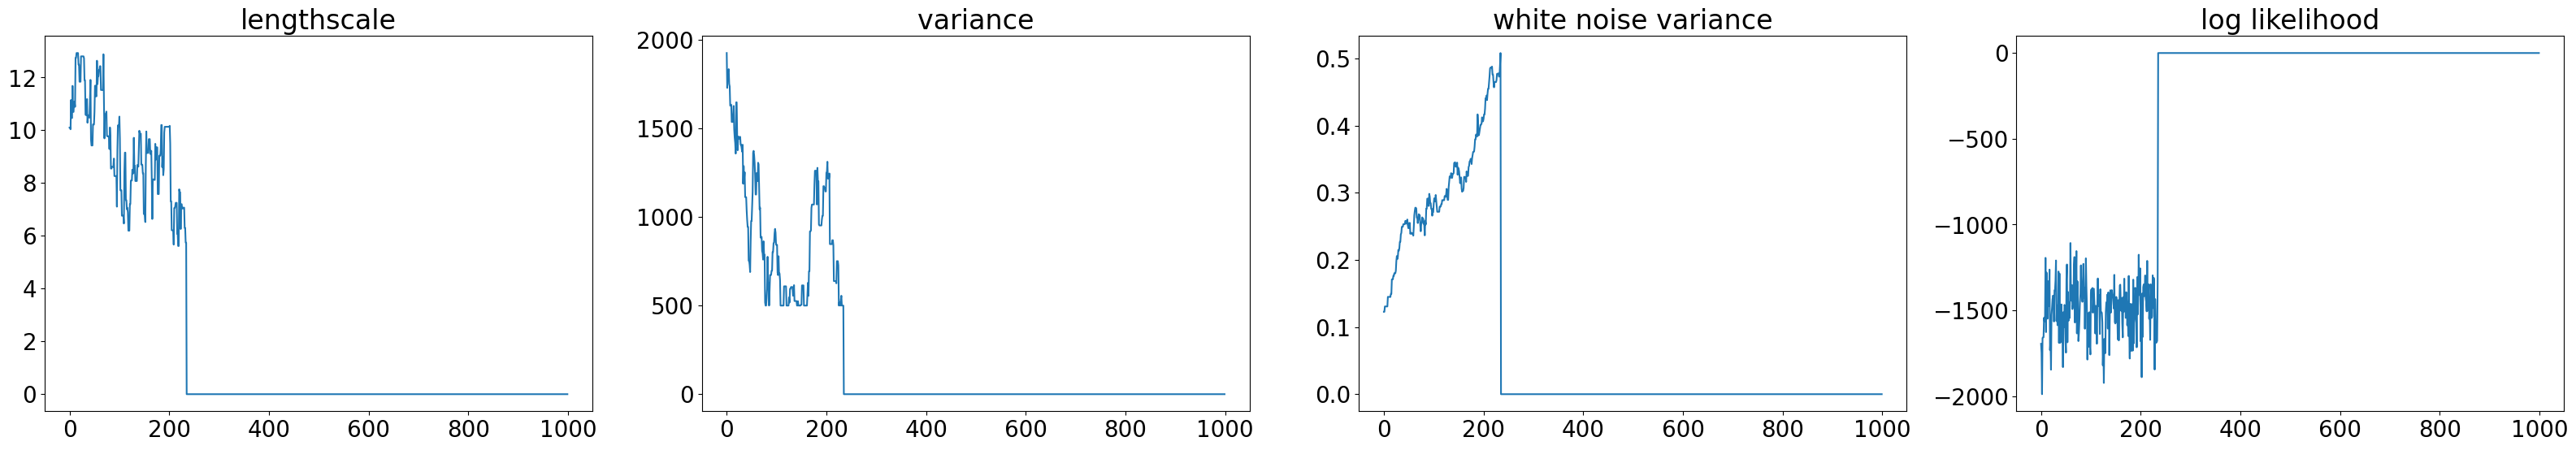

In [106]:
plt.figure(figsize=(40,6))
plt.subplot(141)
plt.plot(np.arange(1000),post_length[:1000])
plt.title('lengthscale')
plt.subplot(142)
plt.plot(np.arange(1000),post_variance[:1000])
plt.title('variance')
plt.subplot(143)
plt.plot(np.arange(1000),post_noise[:1000])
plt.title('white noise variance')
plt.subplot(144)
plt.plot(np.arange(1000),post_log_likelihood[:1000])
plt.title('log likelihood')

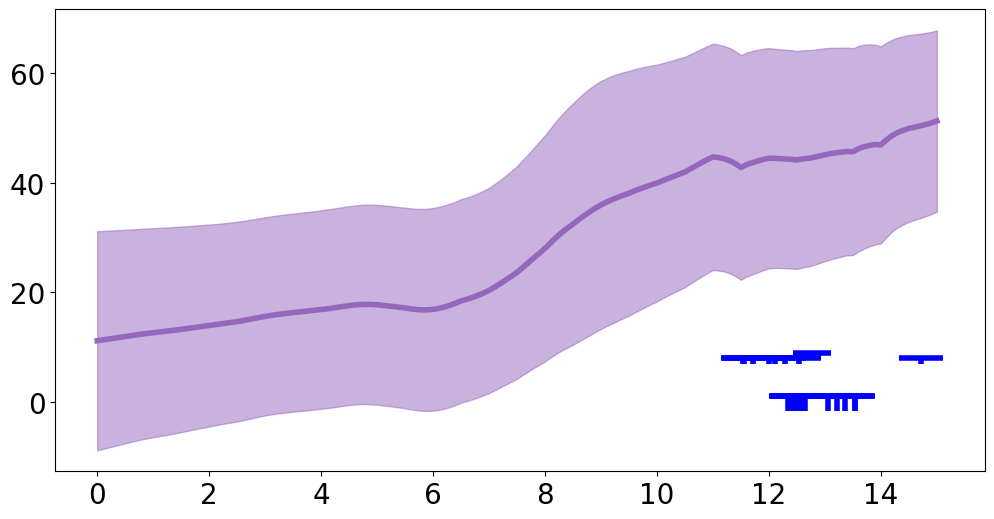

In [124]:
time_mat = np.arange(0,15.1,0.1)
pred_matrix = PSTHM.gen_pred_matrix(time_mat,[43.649],[289.718])
index = X_new[:,1]==43.649
test_y_all = np.zeros([200,151])
gpr.noise = torch.tensor(post_y[i])*0

for i in range(200):
    test_X[:,0] = torch.tensor(post_x[i])
    gpr.X = torch.tensor(test_X)
    gpr.y = torch.tensor(post_y[i])
    gpr.kernel.kern0.kern0.variance= torch.tensor(post_variance[i])
    gpr.kernel.kern0.kern0.lengthscale = torch.tensor(post_length[i])
    gpr.kernel.kern1.variance = torch.tensor(post_noise[i])
    test_y,_ = gpr(pred_matrix)
    test_y_all[i] = test_y.detach().numpy()

# PSTHM.plot_uncertainty_boxes(X_new[:,0][index],y[index],x_sigma[index]*2,y_sigma[index]*2)

# plt.errorbar(X_new[index][:,0].detach().numpy(),y[index],xerr=x_sigma[index],yerr=[[0]*7,2*y_sigma[index]],fmt='None',color='green',label='TL',linewidth=4)
plt.errorbar(X_new[index][:,0].detach().numpy(),y[index],xerr=x_sigma[index],yerr=[2*y_sigma[index],[0]*28],fmt='None',color='blue',label='ML',linewidth=4)

test_y_mean = np.mean(test_y_all,axis=0)
test_y_std = np.std(test_y_all,axis=0)
plt.plot(time_mat,test_y_mean,color='C4',linewidth=4)
plt.fill_between(time_mat,test_y_mean-test_y_std*2,test_y_mean+test_y_std*2,color='C4',alpha=0.5)

In [125]:
time_mat = np.array([13.5]) 
lat_matrix = np.arange(40,47,0.1)
lon_matrix = np.arange(285,300,0.25)
#---------------------------------------------------------------------
pred_matrix = PSTHM.gen_pred_matrix(time_mat,lat_matrix,lon_matrix)
lon_mat,lat_mat = np.meshgrid(lon_matrix,lat_matrix)
output_y = np.zeros((100,70,60))

num = 0
gpr.noise = torch.tensor(post_y[i])*0
test_X = torch.clone(X_new)

for i in tqdm(range(200)):
    test_X[:,0] = torch.tensor(post_x[i])
    gpr.X = torch.tensor(test_X)
    gpr.y = torch.tensor(post_y[i])
    gpr.kernel.kern0.kern0.variance= torch.tensor(post_variance[i])
    gpr.kernel.kern0.kern0.lengthscale = torch.tensor(post_length[i])
    gpr.kernel.kern1.variance = torch.tensor(post_noise[i])
    gpr.kernel.kern0.kern1.s_lengthscale = torch.tensor(post_s_length[i])
    test_y,_ = gpr(pred_matrix)
    output_y[num] = test_y.detach().numpy().reshape([70,60])
    num+=1

  0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'GP Prediction at: 12.5 CE')

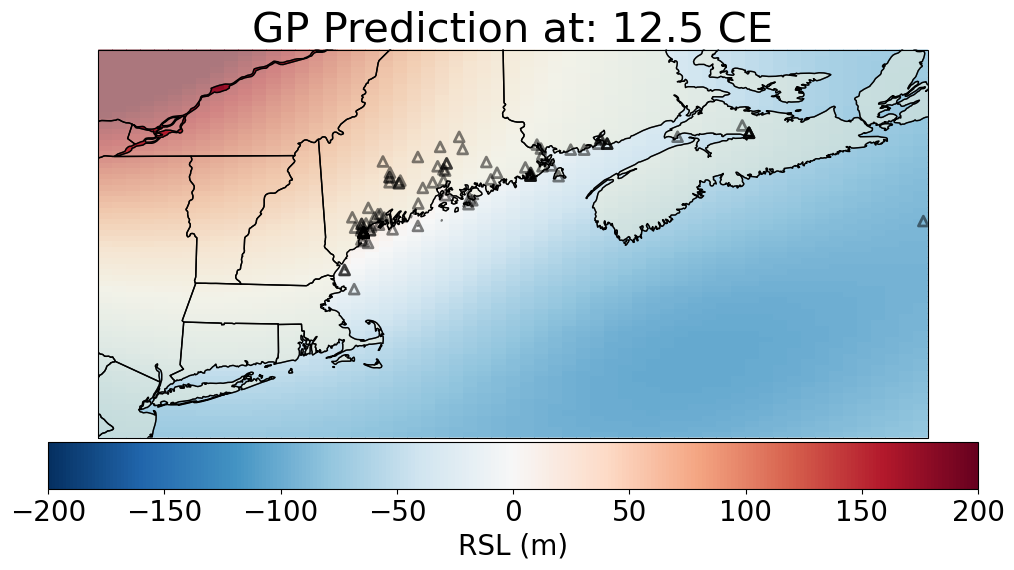

In [883]:

age_index = (X_new[:,0]<14)&(X_new[:,0]>12)

plt.plot(figsize=(12,8))
ax2 = plt.subplot(111,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,GIA_mean,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=200,vmin=-200,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
ax2.scatter(X_new[:,2].detach().numpy()[age_index],X_new[:,1].detach().numpy()[age_index],
            c='None',s=50,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2,alpha=0.5)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

Text(0.5, 1.0, 'GP Prediction at: 13.5 CE')

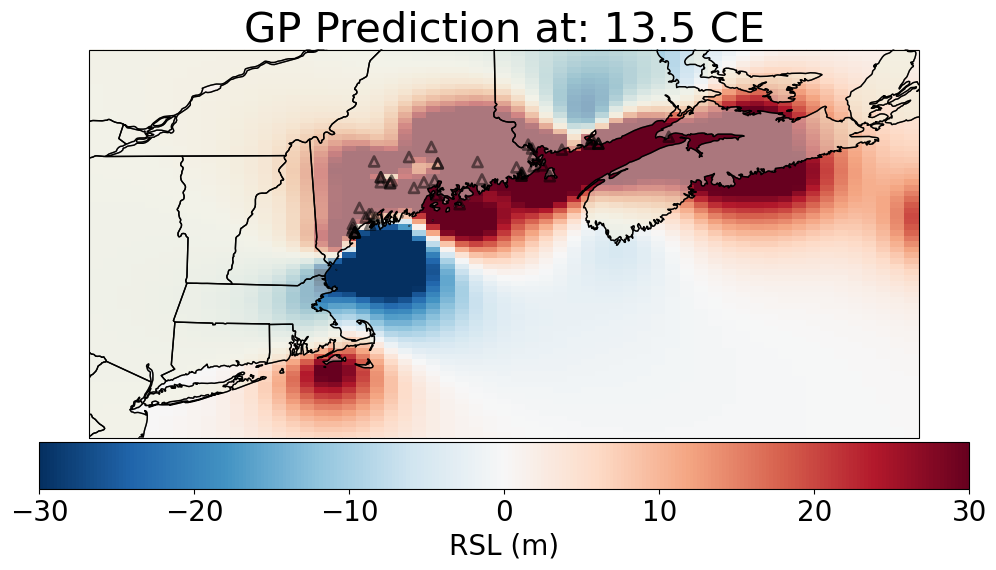

In [133]:
mean_y = np.mean(output_y,axis=0)
GIA_mean = gpr.mean_function(pred_matrix).detach().numpy().reshape([70,60])

age_index = (X_new[:,0]<14)&(X_new[:,0]>13)

plt.plot(figsize=(12,8))
ax2 = plt.subplot(111,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,mean_y-GIA_mean,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=30,vmin=-30,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
ax2.scatter(X_new[:,2].detach().numpy()[age_index],X_new[:,1].detach().numpy()[age_index],
            c='None',s=50,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2,alpha=0.5)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)

Text(0.5, 1.0, 'GP Prediction at: 13.5 CE')

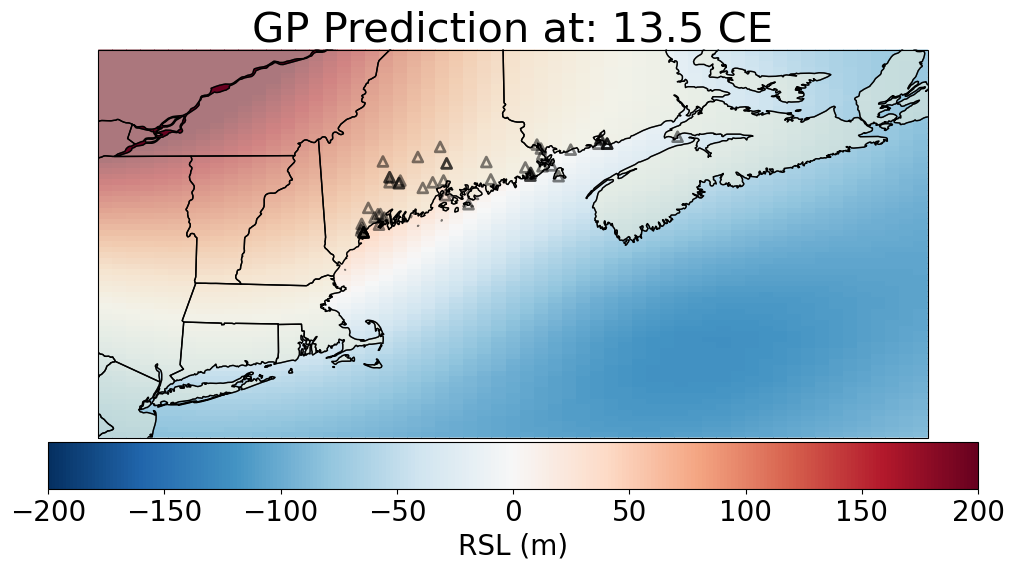

In [129]:
mean_y = np.mean(output_y,axis=0)
GIA_mean = gpr.mean_function(pred_matrix).detach().numpy().reshape([70,60])

age_index = (X_new[:,0]<14)&(X_new[:,0]>13)

plt.plot(figsize=(12,8))
ax2 = plt.subplot(111,projection=ccrs.PlateCarree())
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.add_feature(cfeature.STATES, edgecolor='black', zorder=0)
cax = ax2.pcolor(lon_mat,lat_mat,GIA_mean,transform=ccrs.PlateCarree(),cmap='RdBu_r',vmax=200,vmin=-200,zorder=0)
cbar = fig.colorbar(cax, ax=ax2, orientation='horizontal', pad=0.01)
ax2.scatter(X_new[:,2].detach().numpy()[age_index],X_new[:,1].detach().numpy()[age_index],
            c='None',s=50,transform=ccrs.PlateCarree(),zorder=20,marker='^',edgecolor='k',linewidth=2,alpha=0.5)
cbar.set_label('RSL (m)')
ax2.set_title('GP Prediction at: {:} CE'.format(time_mat[0]),fontsize=30)